# About Penalty Method

The FWI problem:
$$\min_{M\times U}\ J(m,u) = \frac{1}{2}\|Pu-d\|_2^2 \\  \text{s.t. } A(m) u = q.$$

Penalty problem:
$$\min_{M\times U}\ J(m,u) = \frac{1}{2}\|Pu-d\|_2^2 + \frac{\lambda^2}{2} \|A(m)u-q\|_2^2.$$

To solve the penalty problem:
1. Compute $u_\lambda$ such that $D_u J(m,u_\lambda) = 0$.

$$D_u J(m,u_\lambda) = 0 \Leftarrow P'(Pu-d) + \lambda^2 A(m)'(A(m)u-q) = 0 \\ 
\Leftarrow \begin{pmatrix}\lambda A(m)'A(m) \\P'P  \end{pmatrix} u = \begin{pmatrix} A'(m)q \\ P'd\end{pmatrix}.$$

Suppose the dimension of the problem be $N$, then the size of the linear system is $2N\times N$.
2. Compute the gradient by fixing $u_\lambda$.
$$g = \omega^2\frac{\partial A(m)u_\lambda}{m} (A(m)u_\lambda - q).$$

Here is a trick:

Instead of solving the tall linear system in 1, the author solve a square linear system like:
$$(\lambda A(m)'A(m) + P'P) u = (A(m)'q + P'd).$$
In this case the size of the linear system turn into $N\times N$.

## Our Approach

In our approach we trying to reduce the size of the linear system by fixing the data space.
Here we divide the status space by two parts $U=U_1 \oplus U_2 = D \oplus U_2$, and then fix $d\in D$, here $D$ is the data space.

Then the misfit function become:
$$\min_{M\times U_2}\ J(m,u_2) =\frac{\lambda^2}{2} \|A(m)u-q\|_2^2.$$

Introducing a pivot matrix $R$, then, 
$$
\begin{align*}
\min_{M\times U_2}\ J(m,u_2) =\frac{\lambda^2}{2} \|A(m)u-q\|_2^2 = \frac{\lambda^2}{2} \|A(m) R' R u - q\|_2^2 \\
= \frac{\lambda^2}{2} \|\begin{pmatrix}A_1 & A_2 \end{pmatrix} \begin{pmatrix}d \\ u_2 \end{pmatrix} - q\|.
\end{align*}
$$

To compute the $u_\lambda$ as in penalty method, a different linear system need to be solved,
$$A_1 d + A_2 u_2 = q \Leftrightarrow  A_2 u_2 = q- A_1 d \Leftrightarrow A_2'  A_2 u_2 = A_2' (q- A_1 d).$$

Let $N_2$ be the dimension of $U_2$, then the size of linear system is $N_2 \times N_2$.

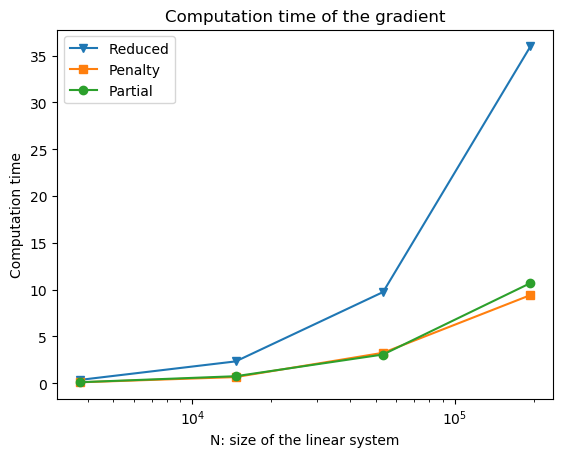

PyObject <matplotlib.legend.Legend object at 0x13dde6a58>

In [95]:
time_reduced = [0.357768, 2.338970, 9.748888, 36.001707]
time_penalty = [0.102244, 0.663404, 3.257971, 9.423534]
time_partial = [0.112994, 0.754549, 3.074852, 10.707791]
prob_size = [(51+10)^2, (101+20)^2, (201+30)^2, (401+40)^2]
semilogx(prob_size, time_reduced, "-v", prob_size, time_penalty, "-s", prob_size, time_partial, "-o"); 
xlabel("N: size of the linear system")
ylabel("Computation time")
title("Computation time of the gradient")
legend(["Reduced", "Penalty", "Partial"])

In [41]:
include("program/model.jl")
include("program/make_diff_op.jl")
include("program/make_projection_op.jl")
include("program/make_source_vec.jl")
include("program/draw_figure.jl")
include("program/compute_gradient.jl")
include("program/reduced_prob.jl")

lbfgsb_fwi (generic function with 1 method)

## Model 1

In [57]:
Nx = 51; Ny = 51;
dx = 20; dy = 20;
pml_len = 10;
Nx_pml = Nx + 2*pml_len;
Ny_pml = Ny + 2*pml_len;

coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = i;
    coor_source[i,2] = 2;
end

coor_receiver = ones(Int,51, 2);
for i = 1:51
    coor_receiver[i,1] = i;
    coor_receiver[i,2] = 50;
end

model1 = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel0 = 2000*ones(model1.Nx, model1.Ny);
vel = 2000*ones(model1.Nx, model1.Ny);
vel[21:31, 21:31] .= 2100;
vel0_ex = extend_vel(vel0, model1);
vel_ex = extend_vel(vel, model1);

vel_ex1 = reshape(vel_ex, Nx_pml*Ny_pml)
vel0_ex1 = reshape(vel0_ex, Nx_pml*Ny_pml);

Pr = make_projection_op(model1);
fre = 10;
A = make_diff_op(vel_ex1, model, fre);
q = make_source_vec(model);
u = A \ q;
d = Pr * u;

lambda = 1;
Nr, R = pivot_mat(model);
@time f, g = compute_gradient_lbfgsb(vel0_ex1, model1, fre, d, q, Pr);
@time f, g = compute_gradient_penalty(vel0_ex1, model1, fre, d, q, Pr, lambda);
@time f, g = compute_gradient_partial(vel0_ex1, model1, fre, d, q, Pr, Nr, R);

  0.357768 seconds (1.79 k allocations: 96.645 MiB, 2.59% gc time)
  0.102244 seconds (16.38 k allocations: 71.558 MiB, 8.22% gc time)
  0.112994 seconds (31.33 k allocations: 76.592 MiB, 8.55% gc time)


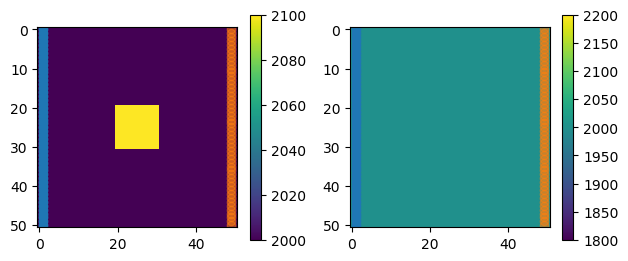

In [32]:
draw_model2(vel_ex1, vel0_ex1, model1, vertial=false)

## Model 2

In [64]:
Nx = 101; Ny = 101;
dx = 10; dy = 10;
pml_len = 20;
Nx_pml = Nx + 2*pml_len;
Ny_pml = Ny + 2*pml_len;

coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = (i-1)*2+1;
    coor_source[i,2] = 2;
end

coor_receiver = ones(Int,51, 2);
for i = 1:51
    coor_receiver[i,1] =  (i-1)*2+1;
    coor_receiver[i,2] = 100;
end

model2 = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel0 = 2000*ones(model2.Nx, model2.Ny);
vel = 2000*ones(model2.Nx, model2.Ny);
vel[41:61, 41:61] .= 2100;
vel0_ex = extend_vel(vel0, model2);
vel_ex = extend_vel(vel, model2);

vel_ex2 = reshape(vel_ex, Nx_pml*Ny_pml)
vel0_ex2 = reshape(vel0_ex, Nx_pml*Ny_pml);

Pr = make_projection_op(model2);
fre = 10;
A = make_diff_op(vel_ex2, model2, fre);
q = make_source_vec(model2);
u = A \ q;
d = Pr * u;

lambda = 1;
Nr, R = pivot_mat(model2);
@time f, g = compute_gradient_lbfgsb(vel0_ex2, model2, fre, d, q, Pr);
@time f, g = compute_gradient_penalty(vel0_ex2, model2, fre, d, q, Pr, lambda);
@time f, g = compute_gradient_partial(vel0_ex2, model2, fre, d, q, Pr, Nr, R);

  2.338970 seconds (2.50 k allocations: 389.027 MiB, 10.20% gc time)
  0.663404 seconds (61.61 k allocations: 293.490 MiB, 20.12% gc time)
  0.754549 seconds (121.08 k allocations: 311.180 MiB, 20.11% gc time)


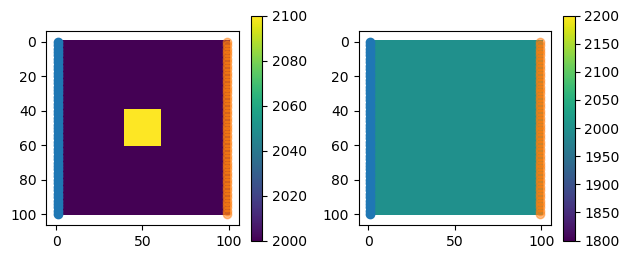

In [25]:
draw_model2(vel_ex2, vel0_ex2, model2, vertial=false)

## Model 3

In [68]:
Nx = 201; Ny = 201;
dx = 10; dy = 10;
pml_len = 30;
Nx_pml = Nx + 2*pml_len;
Ny_pml = Ny + 2*pml_len;

coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = (i-1)*4+1;
    coor_source[i,2] = 2;
end

coor_receiver = ones(Int,51, 2);
for i = 1:51
    coor_receiver[i,1] =  (i-1)*4+1;
    coor_receiver[i,2] = 200;
end

model3 = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel0 = 2000*ones(model3.Nx, model3.Ny);
vel = 2000*ones(model3.Nx, model3.Ny);
vel[81:121, 81:121] .= 2100;
vel0_ex = extend_vel(vel0, model3);
vel_ex = extend_vel(vel, model3);

vel_ex3 = reshape(vel_ex, Nx_pml*Ny_pml)
vel0_ex3 = reshape(vel0_ex, Nx_pml*Ny_pml);

Pr = make_projection_op(model3);
fre = 10;
A = make_diff_op(vel_ex3, model3, fre);
q = make_source_vec(model3);
u = A \ q;
d = Pr * u;

lambda = 1;
Nr, R = pivot_mat(model3);
@time f, g = compute_gradient_lbfgsb(vel0_ex3, model3, fre, d, q, Pr);
@time f, g = compute_gradient_penalty(vel0_ex3, model3, fre, d, q, Pr, lambda);
@time f, g = compute_gradient_partial(vel0_ex3, model3, fre, d, q, Pr, Nr, R);

  9.748888 seconds (3.51 k allocations: 1.336 GiB, 5.40% gc time)
  3.257971 seconds (207.34 k allocations: 1.014 GiB, 20.65% gc time)
  3.074852 seconds (411.53 k allocations: 1.060 GiB, 25.40% gc time)


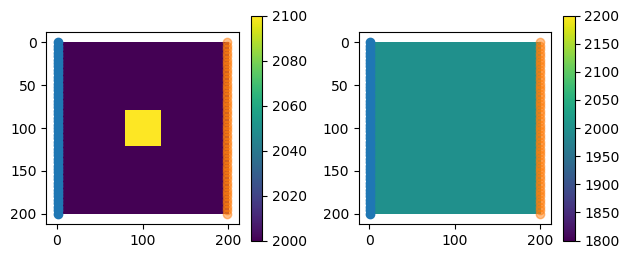

In [27]:
draw_model2(vel_ex3, vel0_ex3, model3, vertial=false)

# Model 4

In [76]:
Nx = 401; Ny = 401;
dx = 10; dy = 10;
pml_len = 40;
Nx_pml = Nx + 2*pml_len;
Ny_pml = Ny + 2*pml_len;

coor_source = ones(Int, 51, 2);
source = -1 .* ones(51);

for i = 1:51
    coor_source[i,1] = (i-1)*8+1;
    coor_source[i,2] = 2;
end

coor_receiver = ones(Int,51, 2);
for i = 1:51
    coor_receiver[i,1] =  (i-1)*8+1;
    coor_receiver[i,2] = 400;
end

model4 = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel0 = 2000*ones(model4.Nx, model4.Ny);
vel = 2000*ones(model4.Nx, model4.Ny);
vel[161:241, 161:241] .= 2100;
vel0_ex = extend_vel(vel0, model4);
vel_ex = extend_vel(vel, model4);

vel_ex4 = reshape(vel_ex, Nx_pml*Ny_pml)
vel0_ex4 = reshape(vel0_ex, Nx_pml*Ny_pml);

Pr = make_projection_op(model4);
fre = 10;
A = make_diff_op(vel_ex4, model4, fre);
q = make_source_vec(model4);
u = A \ q;
d = Pr * u;

lambda = 1;
Nr, R = pivot_mat(model4);
@time f, g = compute_gradient_lbfgsb(vel0_ex4, model4, fre, d, q, Pr);
@time f, g = compute_gradient_penalty(vel0_ex4, model4, fre, d, q, Pr, lambda);
@time f, g = compute_gradient_partial(vel0_ex4, model4, fre, d, q, Pr, Nr, R);

 36.001707 seconds (5.12 k allocations: 4.672 GiB, 2.55% gc time)
  9.423534 seconds (698.67 k allocations: 3.407 GiB, 12.28% gc time)
 10.707791 seconds (1.39 M allocations: 3.728 GiB, 10.03% gc time)


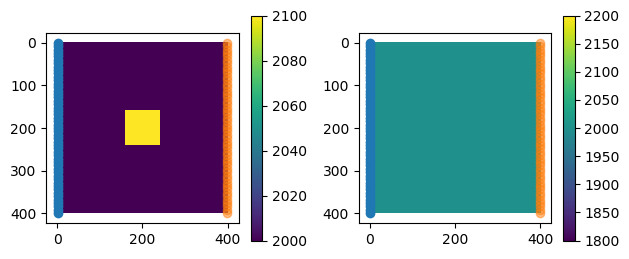

In [74]:
draw_model2(vel_ex4, vel0_ex4, model4, vertial=false)

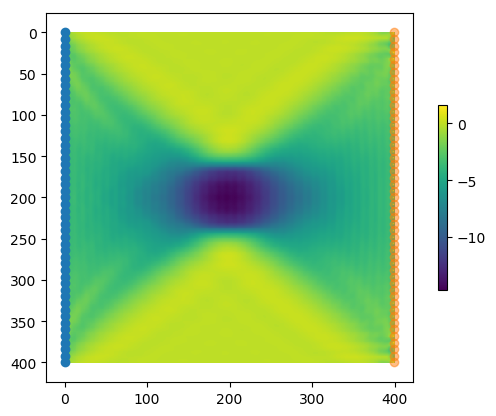

PyObject <matplotlib.collections.PathCollection object at 0x1202c1a20>

In [71]:
draw_model(g, model4)

In [4]:
lower = 2000;
upper = 2200;
fre_vec = [5, 10];
res = lbfgsb_fwi(vel_ex, vel0_ex, model, fre_vec, lower, upper; iterTime=10);

Frequency content is: [5 10]
Frequency is: 5 Hz
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3721     M =            5

At X0      3721 variables are exactly at the bounds

At iterate    0    f=  1.63176D+04    |proj g|=  7.76503D+01

At iterate    1    f=  3.08692D+03    |proj g|=  2.34910D+01

At iterate    2    f=  1.92610D+03    |proj g|=  1.45990D+01

At iterate    3    f=  1.00995D+03    |proj g|=  8.56861D+00

At iterate    4    f=  6.44535D+02    |proj g|=  5.58218D+00

At iterate    5    f=  4.52964D+02    |proj g|=  3.85345D+00

At iterate    6    f=  2.74360D+02    |proj g|=  2.54318D+00

At iterate    7    f=  1.50812D+02    |proj g|=  2.08426D+00

At iterate    8    f=  8.63351D+01    |proj g|=  1.89609D+00

At iterate    9    f=  2.73612D+01    |proj g|=  1.42744D+00

At iterate   10    f=  1.29603D+01    |proj g|=  1.01327D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

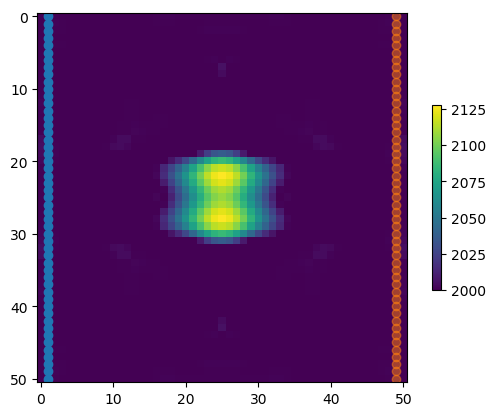

PyObject <matplotlib.collections.PathCollection object at 0x13c72b278>

In [5]:
draw_model(res, model)

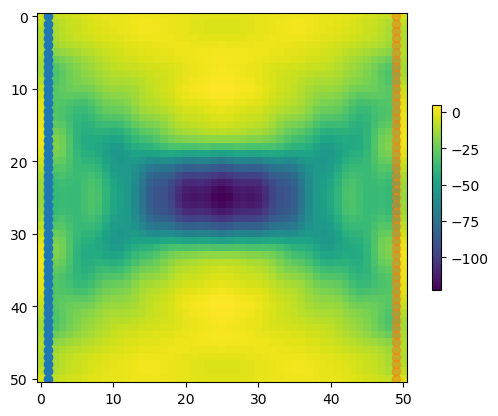

  0.352604 seconds (4.94 k allocations: 71.011 MiB, 10.67% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x13be20a90>

In [6]:
Pr = make_projection_op(model);

fre = 10;
A = make_diff_op(vel_ex, model, fre);

q = make_source_vec(model);

u = A \ q;
d = Pr * u;

@time f, g = compute_gradient_lbfgsb(vel0_ex, model, fre, d, q, Pr);
draw_model(g, model)

In [ ]:
f

In [73]:
include("program/penalty_fwi.jl")
include("program/compute_gradient.jl")
lambda = 1;
lower = 2000;
upper = 2200;
fre_vec = [5, 10];
@time res = penalty_fwi(vel_ex, vel0_ex, model, fre_vec, lower, upper, lambda; iterTime=10);
# res = penalty_fwi(vel_ex, vel0_ex, model, fre_vec; iterTime=10);

Frequency content is: [5 10]
Frequency is: 5 Hz
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3721     M =            5

At X0      3721 variables are exactly at the bounds

At iterate    0    f=  1.32177D+05    |proj g|=  2.00000D+02

At iterate    1    f=  6.99320D+04    |proj g|=  8.35975D+01

At iterate    2    f=  4.61784D+04    |proj g|=  1.11317D+02

At iterate    3    f=  3.23709D+04    |proj g|=  9.54041D+01

At iterate    4    f=  1.48741D+04    |proj g|=  6.79763D+01

At iterate    5    f=  9.86867D+03    |proj g|=  1.59938D+02

At iterate    6    f=  6.95444D+03    |proj g|=  4.11341D+01

At iterate    7    f=  6.04272D+03    |proj g|=  3.92825D+01

At iterate    8    f=  4.74869D+03    |proj g|=  3.40588D+01

At iterate    9    f=  3.72797D+03    |proj g|=  1.62912D+01

At iterate   10    f=  2.51314D+03    |proj g|=  1.32017D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

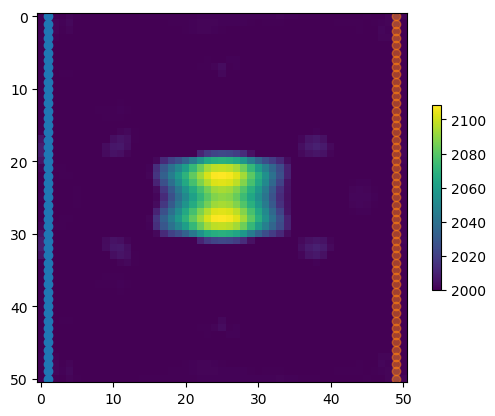

PyObject <matplotlib.collections.PathCollection object at 0x140efb080>

In [74]:
draw_model(res,model)

In [55]:
include("program/compute_gradient.jl")
f, g = compute_gradient_penalty(vel0_ex, model, fre, d, q, Pr, lambda)

(0.0007929712261070095, [-0.284494; -1.70994; … ; -4.53311; -1.58158])

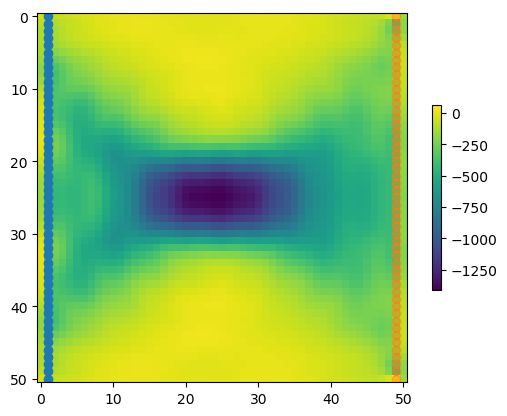

PyObject <matplotlib.collections.PathCollection object at 0x13ded6f28>

In [56]:
draw_model(g, model)

In [31]:
Nr, R = pivot_mat(model);
f, g = compute_gradient_partial(vel0_ex, model, fre, d, q, Pr, Nr, R)

(7929.716259877622, [-0.000201465; -0.0012109; … ; -0.00321011; -0.00111999])

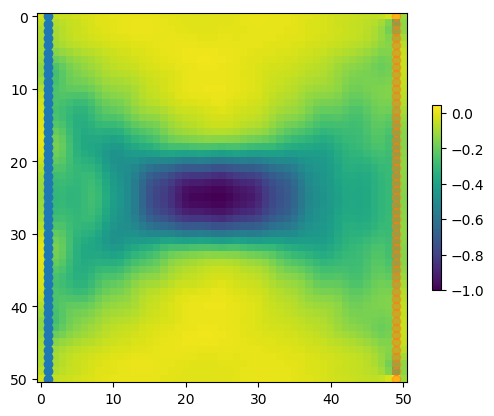

PyObject <matplotlib.collections.PathCollection object at 0x13d192d68>

In [20]:
draw_model(g, model)

In [77]:
include("program/compute_gradient.jl")
include("program/partial_fwi.jl")
lambda = 1;
lower = 2000;
upper = 2200;
fre_vec = [5, 10];
# res = partial_fwi(vel_ex, vel0_ex, model, fre_vec; iterTime=10)
@time res = partial_fwi(vel_ex, vel0_ex, model, fre_vec, lower, upper, lambda; iterTime=10);

Frequency content is: [5 10]
Frequency is: 5 Hz
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3721     M =            5

At X0      3721 variables are exactly at the bounds

At iterate    0    f=  1.32177D+05    |proj g|=  2.00000D+02

At iterate    1    f=  6.99320D+04    |proj g|=  8.35975D+01

At iterate    2    f=  4.61784D+04    |proj g|=  1.11317D+02

At iterate    3    f=  3.23709D+04    |proj g|=  9.54042D+01

At iterate    4    f=  1.48743D+04    |proj g|=  6.79829D+01

At iterate    5    f=  9.86880D+03    |proj g|=  1.59967D+02

At iterate    6    f=  6.95467D+03    |proj g|=  4.11492D+01

At iterate    7    f=  6.04296D+03    |proj g|=  3.92923D+01

At iterate    8    f=  4.74920D+03    |proj g|=  3.40734D+01

At iterate    9    f=  3.72863D+03    |proj g|=  1.62943D+01

At iterate   10    f=  2.51391D+03    |proj g|=  1.31995D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

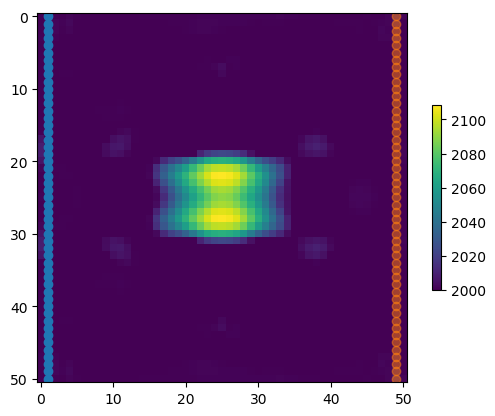

PyObject <matplotlib.collections.PathCollection object at 0x140788eb8>

In [78]:
draw_model(res,model)

In [9]:
using JLD2
@load "data/overthrust_small.jld2" vel_true vel_init
vel_true = copy(vel_true');
vel_init = copy(vel_init');

Nx, Ny = size(vel_true)
dx = 25; dy = 25
pml_len = 30;

# source and receiver
coor_source = ones(Int, 101, 2);
source = -1 .* ones(101);

for i = 1:101
    coor_source[i,1] = 2;
    coor_source[i,2] = (i-1)*4+1;
end

coor_receiver = ones(Int,101, 2);
for i = 1:101
    coor_receiver[i,1] = 2;
    coor_receiver[i,2] = (i-1)*4+1;
end

model = Model(Nx, Ny, dx, dy, coor_source, source, coor_receiver, pml_len);

vel_true = extend_vel(vel_true, model);
vel_init = extend_vel(vel_init, model);
Nx_pml = model.Nx + 2*pml_len;
Ny_pml = model.Ny + 2*pml_len;
vel_true = reshape(vel_true, Nx_pml*Ny_pml);
vel_init = reshape(vel_init, Nx_pml*Ny_pml);

# Solve the equation A(m)u = q
Pr = make_projection_op(model);
fre = 5;
A = make_diff_op(vel_true, model, fre);
q = make_source_vec(model);
@time u = A \ q;|
d = Pr * u;

 12.505214 seconds (607 allocations: 1.198 GiB, 4.39% gc time)


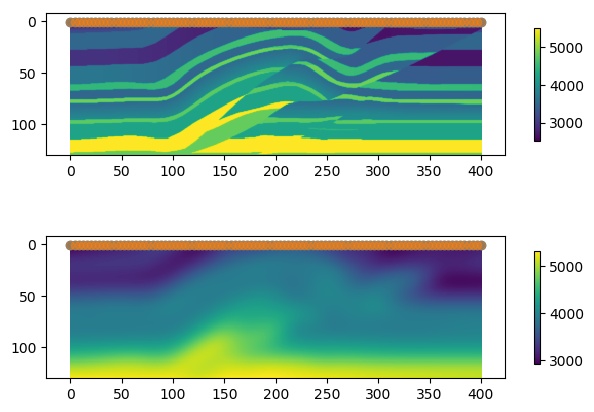

In [3]:
draw_model2(vel_true, vel_init, model; vertial=true)

In [ ]:
include("program/penalty_fwi.jl")
include("program/partial_fwi.jl")
include("program/compute_gradient.jl")
lambda = 1;
upper = maximum(vel_true);
lower = minimum(vel_true);
fre_vec = [5 10 15];
# @time res = penalty_fwi(vel_true, vel_init, model, fre_vec, lower, upper, lambda; iterTime=5);
# @time res = lbfgsb_fwi(vel_true, vel_init, model, fre_vec, lower, upper; iterTime=5);
@time res = partial_fwi(vel_true, vel_init, model, fre_vec, lower, upper, lambda; iterTime=5);

Frequency content is: [5; 10; 15]
Frequency is: 5 Hz
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        88051     M =            5

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60034D+07    |proj g|=  2.27772D+03

At iterate    1    f=  7.87277D+06    |proj g|=  2.66563D+03

At iterate    2    f=  3.27200D+06    |proj g|=  7.81112D+02

At iterate    3    f=  2.85072D+06    |proj g|=  7.77450D+02

At iterate    4    f=  2.09334D+06    |proj g|=  1.30525D+03

At iterate    5    f=  1.87650D+06    |proj g|=  2.00339D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro

In [ ]:
draw_model2(vel_init, res, model)

In [27]:
include("program/compute_gradient.jl")
@time f, g = compute_gradient_penalty(vel_init, model, fre, d, q, Pr, lambda)
# @time f, g = compute_gradient_lbfgsb(vel_init, model, fre, d, q, Pr)

  9.053152 seconds (331.40 k allocations: 2.056 GiB, 16.06% gc time)


(1.6003351419569194e7, [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

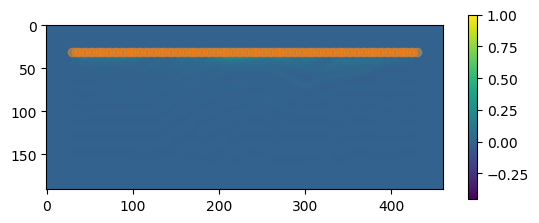

PyObject <matplotlib.collections.PathCollection object at 0x13c5586d8>

In [28]:
draw_model(g, model,ex_model=true)
# draw_wavefield(u, model)

In [ ]:
Pr = make_projection_op(model);

fre = 10;
A = make_diff_op(vel_ex, model, fre);

q = make_source_vec(model);

u = A \ q;
d = Pr * u;

In [ ]:
lambda = 1;
A = make_diff_op(vel0_ex, model, fre);
A_lambda = [lambda * A; Pr];
q_lamda = [lambda * q; d];

@time u_lambda = A_lambda \ q_lamda;

In [ ]:
draw_wavefield(u_lambda, model, index=26, ex_model=false)

In [ ]:
draw_model(real(u_lambda - u)[:,26], model, ex_model=false)

In [ ]:
v = A * u_lambda - q;

In [ ]:
draw_wavefield(v, model, index=26)

In [ ]:
g = real(sum(conj(u_lambda) .* (A * u_lambda - q), dims=2));

In [ ]:
function compute_gradient_penalty(vel, model, fre, d, q, Pr, lambda)
    A = make_diff_op(vel, model, fre);
#     A_lambda = [lambda * A; Pr];
#     q_lamda = [lambda * q; d]; 
    A_lambda = lambda*(A'*A) + (Pr'*Pr);
    q_lambda = Pr'*d + lambda*A'*q;
    u_lambda = A_lambda \ q_lambda;
    v = A * u_lambda - q;
    g = real(sum(conj(u_lambda) .* v, dims=2));
    f = 0.5 * norm(real(Pr*real(u_lambda)-d))^2 + (lambda^2/2)*norm(real(v))^2;
    
    return f, g
end


In [ ]:
Pr = make_projection_op(model);

fre = 10;
A = make_diff_op(vel_ex, model, fre);

q = make_source_vec(model);

u = A \ q;
d = Pr * u;

In [ ]:
lambda = 1;
@time f, g = compute_gradient_penalty(vel0_ex, model, fre, d, q, Pr, lambda)

In [ ]:
draw_model(g, model)

In [ ]:
function pivot_mat(model)
    coor_receiver = model.coor_receiver .+ model.pml_len;
    Nx_pml = model.Nx + 2*model.pml_len;
    Ny_pml = model.Ny + 2*model.pml_len;
    nr = size(coor_receiver,1);

    ii = 1:nr;
    jj = zeros(Int, 1,nr);
    for i = 1:nr
       jj[i] = coor_receiver[i,1]+(coor_receiver[i,2]-1)*Nx_pml;
    end
    kk = ones(1,nr);
    R = sparse(1I, Nx_pml*Ny_pml, Nx_pml*Ny_pml);
    for i = 1:nr
        temp = R[jj[i],:];
        R[jj[i],:] = R[i,:];
        R[i,:] = temp;
    end
    return nr, R
end

function compute_gradient_partial(vel, model, fre, d, q, Pr, Nr, R)
    
    lambda = 1;
    
    A0 = make_diff_op(vel0_ex, model, fre);
    A_temp = A0 * R';
    A1 = A_temp[:, 1:Nr];
    A2 = A_temp[:, Nr+1:end];
    q_temp = q - A1 * d;
#     u2 = A2 \ q_temp;
    u2 = (A2'*A2) \ (A2'*q_temp);
    u_temp = [d; u2];
    u0 = R' * u_temp;
    
    v = A0 * u0 - q;
    g = real(sum(conj(u0) .* v, dims=2));
    f = 0.5 * norm(real(Pr*real(u0)-d))^2 + (lambda^2/2)*norm(real(v))^2;
    
    return f, g
end

In [ ]:
Nr, R = pivot_mat(model);
@time f, g = compute_gradient_partial(vel0_ex, model, fre, d, q, Pr, Nr, R);

In [ ]:
draw_model(g, model)

In [ ]:
@time f,g = compute_gradient_lbfgsb(vel0_ex, model, fre, d, q, Pr)

In [ ]:
draw_model(g, model)

In [ ]:
A0 = make_diff_op(vel0_ex, model, fre);
A_temp = A0 * R';
A1 = A_temp[:, 1:Nr];
A2 = A_temp[:, Nr+1:end];
q_temp = q - A1 * d;
@time u2 = (A2'*A2) \ (A2'*q_temp);
@time uu2 = A2\ (q_temp);

In [ ]:
@time uu = A0 \ q;

In [ ]:
maximum(abs)

In [ ]:
u_temp = [d; u2];
u0 = R' * u_temp;

$A(m) R^T R u_\lambda$

In [ ]:
draw_wavefield(u0-u, model, index=26)

In [ ]:
71 * 71

In [ ]:
ii = 1:size(model.coor_receiver,1)

In [ ]:
jj = zeros(1,size(model.coor_receiver,1))

In [ ]:
model_size = Nx_pml * Ny_pml;
for i = 1:size(model.coor_receiver,1)
   jj[i] = model.coor_receiver[i,1]+(model.coor_receiver[i,2]-1)*Nx_pml;
end

In [ ]:
kk = ones(1,size(model.coor_receiver,1));

In [ ]:
R = speye(Nx_pml*Ny_pml);

In [ ]:
for i = 1:size(coor_receiver,1)
    temp = R(jj(i),:);
    R(jj(i),:) = R(i,:);
    R(i,:) = temp;
end

In [ ]:
A = [1 2 ;3 4]
norm(A)^2

In [ ]:
1^2 + 2^2 + 3^2 + 4^2

In [ ]:
    Nx_pml = model.Nx + 2*model.pml_len
    Ny_pml = model.Ny + 2*model.pml_len

    vel = copy(vel0);
    iter_time = 0
    p = similar(q[:,1])

        f0, g0 = compute_gradient(vel0_ex, model, fre, d, q, Pr)
        
        p = -1 * g0 / maximum(abs.(g0));

In [ ]:
draw_wavefield(p, model)

In [ ]:
lambda = 100
s0 = p;
max_value = 2100
min_value = 1950

v = vel0_ex + lambda * reshape(s0, Nx_pml, Ny_pml);
v[v .> max_value] .= max_value;
v[v .< min_value] .= min_value;

imshow(v); colorbar()

In [ ]:
lambda = linesearch(vel0_ex, fre, model, q, d, Pr, f0, g0, s0, 100, max_value, min_value)

In [ ]:
v = vel0_ex + lambda * reshape(s0, Nx_pml, Ny_pml);
v[v .> max_value] .= max_value;
v[v .< min_value] .= min_value;

draw_model(v, model)

In [ ]:
x = randn(30, 50);

In [ ]:
imshow(x); colorbar(shrink=0.5); title("HAHA")